# Feedforward and Feedback Effects of Microstimulation Reveal Neural Mechanisms of Texture Segregation (v1.0)
## Elaboró: Anette Paulina González Solano

En este experimento se registró actividad neuronal extracelular en dos áreas visuales de monos despiertos: V1 (corteza visual primaria) y V4 (área visual extraestriada). Los animales realizaron una tarea de segregación figura–fondo con texturas de barras. En algunos ensayos se aplicó microestimulación eléctrica en V1 o en V4 mientras se presentaba una figura.

En los archivos `V1MS_FIG.mat` y `V4MS_FIG.mat` se resume la actividad durante ensayos:

- `V1MS_FIG.mat`: actividad cuando la microestimulación se aplica en V1.
- `V4MS_FIG.mat`: actividad cuando la microestimulación se aplica en V4.

Cada archivo contiene una matriz llamada `UNITS` de tamaño (tiempo × canales × condición). En este proyecto vamos a:

1. Extraer una condición de `UNITS` para V1 y para V4.
2. Construir una matriz de conectividad funcional (por correlación) entre canales de V1 y entre canales de V4.
3. Usar estas matrices como base para los análisis de umbral, grafos y métricas de red, comparando la organización de la red en V1 vs V4.

# Código

In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar datos de V1 (ensayos FIG con microestimulación en V1)
v1_mat = sio.loadmat(r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S06_proyecto\proyecto-apgsolano\V1MS_FIG.mat")
v1_ms = v1_mat["V1MS"][0, 0]   # sacar el struct interno

# Cargar datos de V4 (ensayos FIG con microestimulación en V4)
v4_mat = sio.loadmat(r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S06_proyecto\proyecto-apgsolano\V4MS_FIG.mat")
v4_ms = v4_mat["V4MS"][0, 0]

# UNITS tiene forma (tiempo, canales, condiciones)
units_v1 = v1_ms["UNITS"]
units_v4 = v4_ms["UNITS"]

print("UNITS V1:", units_v1.shape)  # (n_tiempo, n_canales_V1, n_condiciones)
print("UNITS V4:", units_v4.shape)  # (n_tiempo, n_canales_V4, n_condiciones)

UNITS V1: (381, 232, 4)
UNITS V4: (381, 318, 4)


In [3]:
# Elegimos la primera condición (índice 0)
condicion = 0

# Para V1: pasamos de (tiempo, canales, condiciones) a (canales, tiempo)
datos_v1 = units_v1[:, :, condicion].T   # (canales_V1, tiempo)

# Para V4: igual
datos_v4 = units_v4[:, :, condicion].T   # (canales_V4, tiempo)

print("Datos V1:", datos_v1.shape)
print("Datos V4:", datos_v4.shape)

Datos V1: (232, 381)
Datos V4: (318, 381)


In [4]:
# Matriz de correlación entre canales de V1
matriz_v1 = np.corrcoef(datos_v1)

# Matriz de correlación entre canales de V4
matriz_v4 = np.corrcoef(datos_v4)

print("Matriz V1:", matriz_v1.shape)
print("Matriz V4:", matriz_v4.shape)

# Por si hubiera NaNs, los ponemos en 0 (para no romper nada después)
matriz_v1 = np.nan_to_num(matriz_v1, nan=0.0) # Conectividad entre canales de V1 (cuando se estimula V1 en ensayos FIG).
matriz_v4 = np.nan_to_num(matriz_v4, nan=0.0) # Conectividad entre canales de V4 (cuando se estimula V4 en ensayos FIG).

Matriz V1: (232, 232)
Matriz V4: (318, 318)


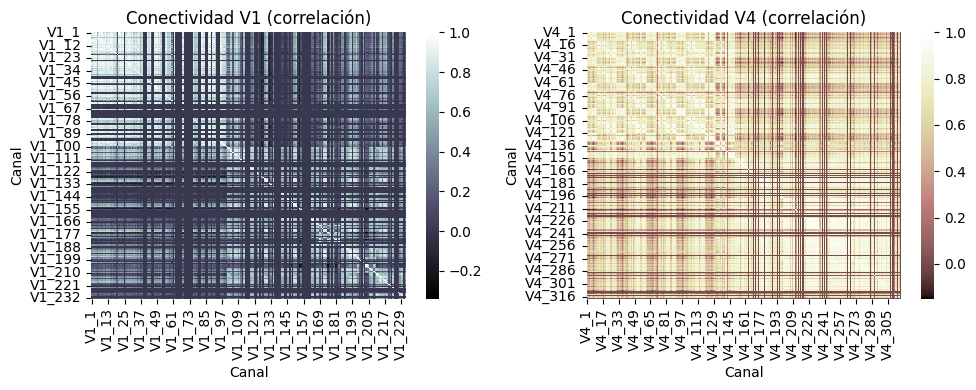

In [5]:
# Creamos índices de canales 
n_can_v1 = matriz_v1.shape[0]
n_can_v4 = matriz_v4.shape[0]

canales_v1 = [f"V1_{i+1}" for i in range(n_can_v1)]
canales_v4 = [f"V4_{i+1}" for i in range(n_can_v4)]

# DataFrames para trabajar más cómodo y usar networkx luego
matriz_v1_df = pd.DataFrame(matriz_v1, index=canales_v1, columns=canales_v1)
matriz_v4_df = pd.DataFrame(matriz_v4, index=canales_v4, columns=canales_v4)

# Heatmaps
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(matriz_v1_df, cmap="bone")
plt.title("Conectividad V1 (correlación)")
plt.xlabel("Canal")
plt.ylabel("Canal")

plt.subplot(1, 2, 2)
sns.heatmap(matriz_v4_df, cmap="pink")
plt.title("Conectividad V4 (correlación)")
plt.xlabel("Canal")
plt.ylabel("Canal")

plt.tight_layout()
plt.show()

In [6]:
# Extraemos valores de conectividad (sin diagonal)
def extraer_valores(matriz, ignore_zeros=True, eps=1e-6):
    m = np.abs(matriz.values)
    i, j = np.triu_indices_from(m, k=1)  # arriba de la diagonal
    vals = m[i, j]
    if ignore_zeros:
        vals = vals[vals > eps]  # nos quedamos con conexiones realmente distintas de 0
    return vals

valores_v1 = extraer_valores(matriz_v1_df, ignore_zeros=True)
valores_v4 = extraer_valores(matriz_v4_df, ignore_zeros=True)

print("V1 - enlaces no cero:", len(valores_v1))
print("V4 - enlaces no cero:", len(valores_v4))

V1 - enlaces no cero: 13203
V4 - enlaces no cero: 43660


In [7]:
# Estadísticos para V1 y V4
def stats_basicos(vals):
    p25 = np.percentile(vals, 25)
    p50 = np.percentile(vals, 50)
    p75 = np.percentile(vals, 75)
    mu = np.mean(vals)
    sigma = np.std(vals)
    var = np.var(vals)
    return p25, p50, p75, mu, sigma, var

p25_v1, p50_v1, p75_v1, mu_v1, sd_v1, var_v1 = stats_basicos(valores_v1)
p25_v4, p50_v4, p75_v4, mu_v4, sd_v4, var_v4 = stats_basicos(valores_v4)

print("V1: p25, p50, p75 =", p25_v1, p50_v1, p75_v1)
print("V1: mu, sd, var   =", mu_v1, sd_v1, var_v1)

print("V4: p25, p50, p75 =", p25_v4, p50_v4, p75_v4)
print("V4: mu, sd, var   =", mu_v4, sd_v4, var_v4)

V1: p25, p50, p75 = 0.15094386165951026 0.3812118838641876 0.6507392188243938
V1: mu, sd, var   = 0.4087867569231022 0.2811427795008154 0.0790412624654441
V4: p25, p50, p75 = 0.5341718083050432 0.6906872857191315 0.8097022313311764
V4: mu, sd, var   = 0.6500419467232279 0.206335482539606 0.04257433135485206


In [8]:
# Definimos algunos umbrales

## V1
thr_v1_p25 = p25_v1
thr_v1_p50 = p50_v1
thr_v1_p75 = p75_v1
thr_v1_mu  = mu_v1
thr_v1_mu_sd = mu_v1 + sd_v1

## V4
thr_v4_p25 = p25_v4
thr_v4_p50 = p50_v4
thr_v4_p75 = p75_v4
thr_v4_mu  = mu_v4
thr_v4_mu_sd = mu_v4 + sd_v4

thr_v1_p25, thr_v1_p50, thr_v1_p75, thr_v1_mu, thr_v1_mu_sd

(np.float64(0.15094386165951026),
 np.float64(0.3812118838641876),
 np.float64(0.6507392188243938),
 np.float64(0.4087867569231022),
 np.float64(0.6899295364239175))

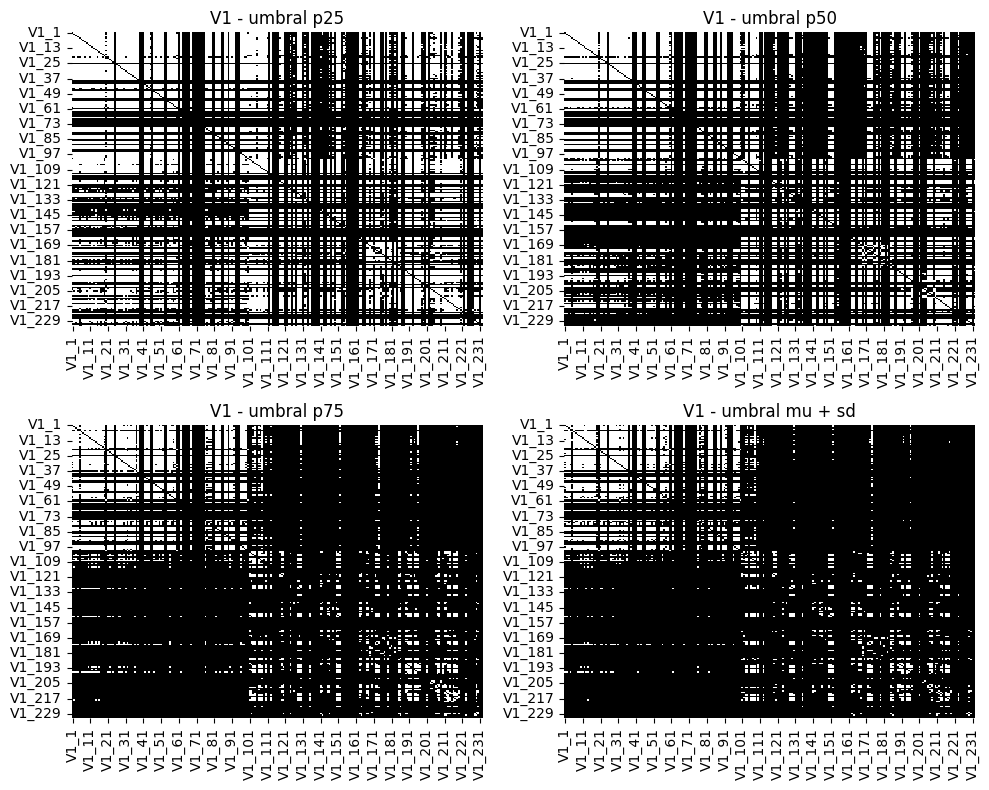

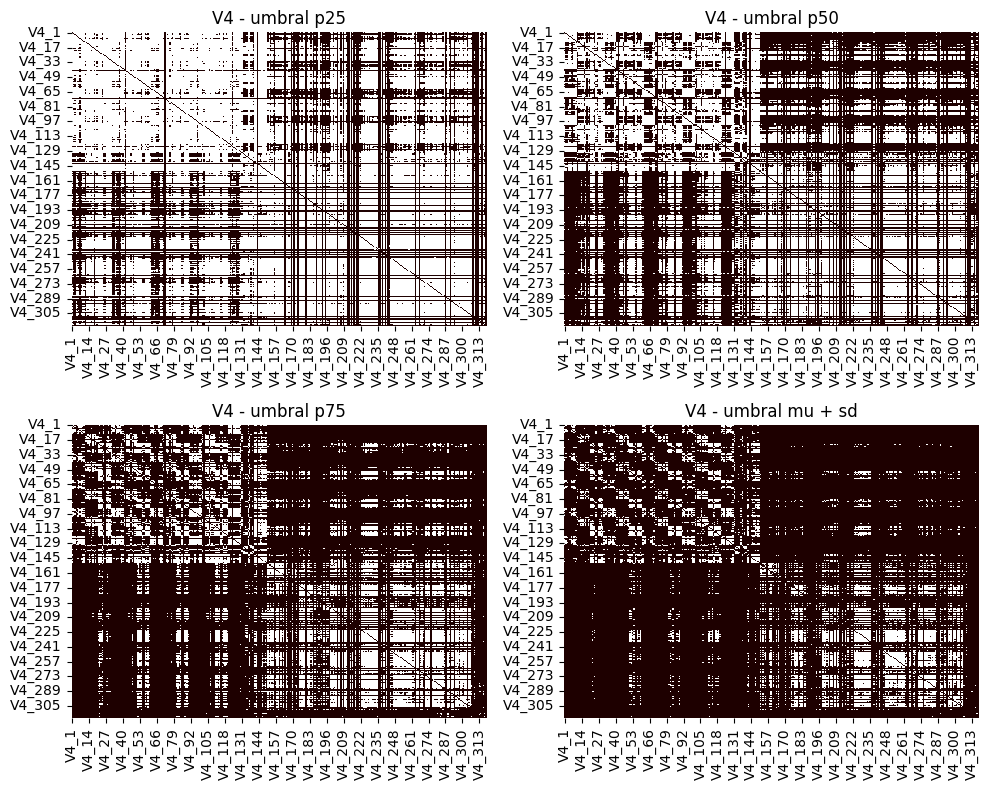

In [9]:
# Función para binarizar las matrices
def binarizar_matriz(matriz, umbral):
    """
    matriz: DataFrame de conectividad (simétrica)
    umbral: valor de corte (sobre |peso|)
    devuelve: DataFrame binario con 0 y 1
    """
    m = np.abs(matriz.values.copy())
    m_bin = (m >= umbral).astype(int)
    np.fill_diagonal(m_bin, 0)  # sin autoconexiones
    return pd.DataFrame(m_bin, index=matriz.index, columns=matriz.columns)

# Creamos algunas matrices binarias para V1 y V4

## Ejemplos de umbrales para V1
A_v1_p25   = binarizar_matriz(matriz_v1_df, thr_v1_p25)
A_v1_p50   = binarizar_matriz(matriz_v1_df, thr_v1_p50)
A_v1_p75   = binarizar_matriz(matriz_v1_df, thr_v1_p75)
A_v1_mu_sd = binarizar_matriz(matriz_v1_df, thr_v1_mu_sd)

## Ejemplos de umbrales para V4
A_v4_p25   = binarizar_matriz(matriz_v4_df, thr_v4_p25)
A_v4_p50   = binarizar_matriz(matriz_v4_df, thr_v4_p50)
A_v4_p75   = binarizar_matriz(matriz_v4_df, thr_v4_p75)
A_v4_mu_sd = binarizar_matriz(matriz_v4_df, thr_v4_mu_sd)

# Heatmaps de matrices binarias 

## V1
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.heatmap(A_v1_p25, cmap="bone", cbar=False)
plt.title("V1 - umbral p25")

plt.subplot(2, 2, 2)
sns.heatmap(A_v1_p50, cmap="bone", cbar=False)
plt.title("V1 - umbral p50")

plt.subplot(2, 2, 3)
sns.heatmap(A_v1_p75, cmap="bone", cbar=False)
plt.title("V1 - umbral p75")

plt.subplot(2, 2, 4)
sns.heatmap(A_v1_mu_sd, cmap="bone", cbar=False)
plt.title("V1 - umbral mu + sd")

plt.tight_layout()
plt.show()

## V4
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.heatmap(A_v4_p25, cmap="pink", cbar=False)
plt.title("V4 - umbral p25")

plt.subplot(2, 2, 2)
sns.heatmap(A_v4_p50, cmap="pink", cbar=False)
plt.title("V4 - umbral p50")

plt.subplot(2, 2, 3)
sns.heatmap(A_v4_p75, cmap="pink", cbar=False)
plt.title("V4 - umbral p75")

plt.subplot(2, 2, 4)
sns.heatmap(A_v4_mu_sd, cmap="pink", cbar=False)
plt.title("V4 - umbral mu + sd")

plt.tight_layout()
plt.show()

In [10]:
# Importar librerías
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency

In [11]:
# Grafos para V1 y V4 usando umbral p75
A_v1_main = A_v1_p75.copy()
A_v4_main = A_v4_p75.copy()

# Construir grafos no dirigidos
G_v1 = nx.from_pandas_adjacency(A_v1_main)
G_v4 = nx.from_pandas_adjacency(A_v4_main)

print("V1 - nodos:", G_v1.number_of_nodes(), "aristas:", G_v1.number_of_edges())
print("V4 - nodos:", G_v4.number_of_nodes(), "aristas:", G_v4.number_of_edges())

V1 - nodos: 232 aristas: 3301
V4 - nodos: 318 aristas: 10915


In [12]:
# Función para calcular métricas de red
def metricas_grafo(G, nombre="Grafo"):
    print("=== Métricas para", nombre, "===")
    
    # Degree
    grados = dict(G.degree())
    grados_val = np.array(list(grados.values()))
    print("Grado medio:", grados_val.mean())
    print("Grado máximo:", grados_val.max())
    
    # Clustering
    C_nodos = nx.clustering(G)
    C_vals = np.array(list(C_nodos.values()))
    print("Clustering medio:", C_vals.mean())
    
    # Componente gigante para path length
    if G.number_of_edges() > 0:
        comp = max(nx.connected_components(G), key=len)
        H = G.subgraph(comp).copy()
        try:
            L = nx.average_shortest_path_length(H)
        except nx.NetworkXError:
            L = np.nan
        print("Path length medio (componente gigante):", L)
    else:
        L = np.nan
        print("Path length medio: no hay aristas")
    
    # Eficiencias
    GE = global_efficiency(G)
    LE = local_efficiency(G)
    print("Global efficiency:", GE)
    print("Local efficiency :", LE)
    
    # Betweenness
    bw = nx.betweenness_centrality(G, normalized=True)
    bw_vals = np.array(list(bw.values()))
    print("Betweenness media:", bw_vals.mean())
    
    # Comunidades y modularidad
    if G.number_of_edges() > 0:
        comunidades = community.greedy_modularity_communities(G)
        Q = community.modularity(G, comunidades)
        print("Nº comunidades:", len(comunidades))
        print("Modularidad Q:", Q)
    else:
        Q = np.nan
        print("Modularidad: no definida (sin aristas)")
    
    return {
        "grados": grados,
        "clustering": C_nodos,
        "betweenness": bw
    }

# Calculamos métricas para V1 y V4
res_v1 = metricas_grafo(G_v1, nombre="V1 (umbral p75)")
res_v4 = metricas_grafo(G_v4, nombre="V4 (umbral p75)")

=== Métricas para V1 (umbral p75) ===
Grado medio: 28.45689655172414
Grado máximo: 87
Clustering medio: 0.49690867903201413
Path length medio (componente gigante): 2.1566277095195283
Global efficiency: 0.22416418761863893
Local efficiency : 0.5548996398395029
Betweenness media: 0.0018789306645378605
Nº comunidades: 90
Modularidad Q: 0.3371917995345521
=== Métricas para V4 (umbral p75) ===
Grado medio: 68.64779874213836
Grado máximo: 163
Clustering medio: 0.670324178064553
Path length medio (componente gigante): 2.013359189829778
Global efficiency: 0.4410835333876008
Local efficiency : 0.7598584016137003
Betweenness media: 0.0023622262789762616
Nº comunidades: 48
Modularidad Q: 0.3046527900914261


In [13]:
# Función para small-world sigma 
def small_world_sigma(G, n_rand=5):
    # Componente gigante
    if G.number_of_edges() == 0:
        return np.nan
    
    comp = max(nx.connected_components(G), key=len)
    H = G.subgraph(comp).copy()
    
    C_real = nx.average_clustering(H)
    try:
        L_real = nx.average_shortest_path_length(H)
    except nx.NetworkXError:
        return np.nan
    
    n = H.number_of_nodes()
    m = H.number_of_edges()
    
    C_rand_list = []
    L_rand_list = []
    
    for _ in range(n_rand):
        R = nx.gnm_random_graph(n, m)
        comp_r = max(nx.connected_components(R), key=len)
        Hr = R.subgraph(comp_r).copy()
        C_rand_list.append(nx.average_clustering(Hr))
        L_rand_list.append(nx.average_shortest_path_length(Hr))
    
    C_rand = np.mean(C_rand_list)
    L_rand = np.mean(L_rand_list)
    
    sigma = (C_real / C_rand) / (L_real / L_rand)
    return sigma

sigma_v1 = small_world_sigma(G_v1)
sigma_v4 = small_world_sigma(G_v4)

print("Small-world sigma V1:", sigma_v1)
print("Small-world sigma V4:", sigma_v4)

Small-world sigma V1: 1.8495918372905025
Small-world sigma V4: 2.249007763847096


Top 10 hubs V1:
[('V1_108', 87), ('V1_174', 82), ('V1_16', 80), ('V1_27', 80), ('V1_10', 79), ('V1_56', 79), ('V1_96', 78), ('V1_12', 77), ('V1_13', 76), ('V1_14', 76)]

Top 10 hubs V4:
[('V4_142', 163), ('V4_283', 150), ('V4_147', 149), ('V4_22', 148), ('V4_208', 148), ('V4_231', 147), ('V4_230', 146), ('V4_289', 146), ('V4_234', 145), ('V4_111', 144)]


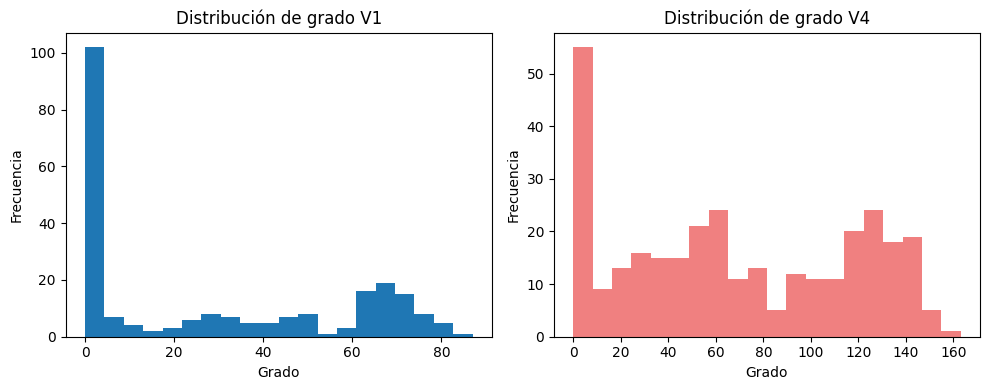

In [14]:
# Hubs y distribución de grados
grados_v1 = res_v1["grados"]
grados_v4 = res_v4["grados"]

# Ordenar por grado
hubs_v1 = sorted(grados_v1.items(), key=lambda x: x[1], reverse=True)[:10]
hubs_v4 = sorted(grados_v4.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 hubs V1:")
print(hubs_v1)

print("\nTop 10 hubs V4:")
print(hubs_v4)

# Histogramas de grado para V1 y V4

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(list(grados_v1.values()), bins=20)
plt.title("Distribución de grado V1")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.hist(list(grados_v4.values()), bins=20, color='lightcoral')
plt.title("Distribución de grado V4")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

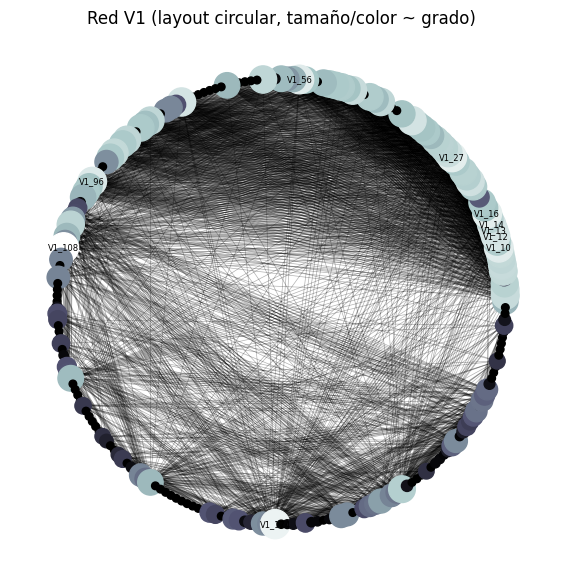

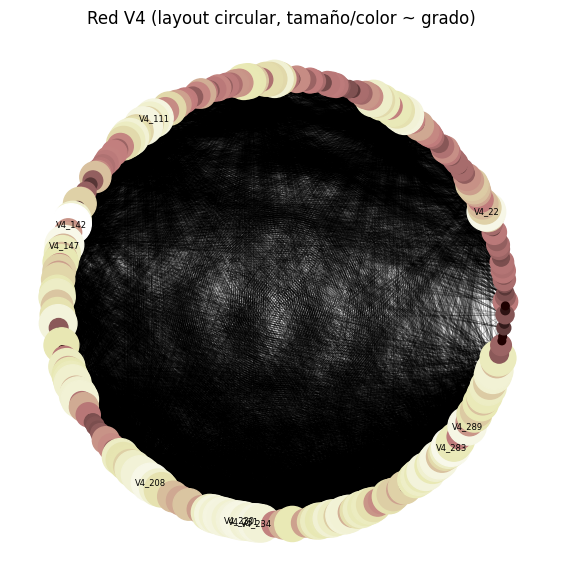

In [15]:
# Plot 2D
import networkx as nx

## V1
pos_v1 = nx.circular_layout(G_v1)
deg_vals_v1 = np.array([grados_v1[n] for n in G_v1.nodes()])
sizes_v1    = 30 + 5*deg_vals_v1
colors_v1   = deg_vals_v1

plt.figure(figsize=(7, 7))
nx.draw_networkx_edges(G_v1, pos_v1, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G_v1, pos_v1,
                       node_size=sizes_v1,
                       node_color=colors_v1,
                       cmap="bone")

# Etiquetar hubs
labels_v1 = {n: n for (n, _) in hubs_v1}
nx.draw_networkx_labels(G_v1, pos_v1, labels=labels_v1, font_size=6)

plt.title("Red V1 (layout circular, tamaño/color ~ grado)")
plt.axis("off")
plt.show()

## V4
pos_v4 = nx.circular_layout(G_v4)
deg_vals_v4 = np.array([grados_v4[n] for n in G_v4.nodes()])
sizes_v4    = 30 + 5*deg_vals_v4
colors_v4   = deg_vals_v4

plt.figure(figsize=(7, 7))
nx.draw_networkx_edges(G_v4, pos_v4, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G_v4, pos_v4,
                       node_size=sizes_v4,
                       node_color=colors_v4,
                       cmap="pink")

# Etiquetar hubs
labels_v4 = {n: n for (n, _) in hubs_v4}
nx.draw_networkx_labels(G_v4, pos_v4, labels=labels_v4, font_size=6)

plt.title("Red V4 (layout circular, tamaño/color ~ grado)")
plt.axis("off")
plt.show()

El dataset NO contiene coordenadas XYZ de los nodos, así que haremos lo siguiente:
- A cada canal de V1 le asignamos una posición en una rejilla XY y ponemos Z=0.
- A cada canal de V4 le asignamos una posición en otra rejilla XY y lo pones en Z=10.

Es decir, ambas rejillas están representadas en planos paralelos (Z=0 y Z=10). NO es un espacio anatómico real, es una disposición esquemática para visualizar la organización de la red.

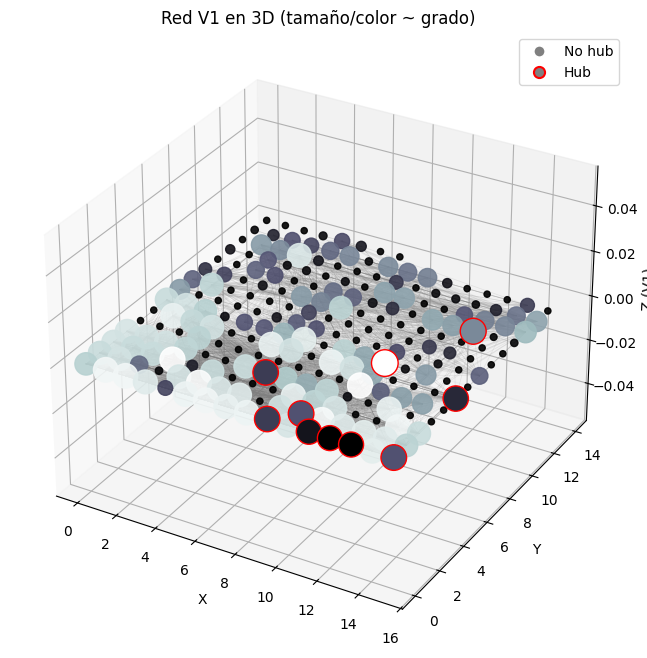

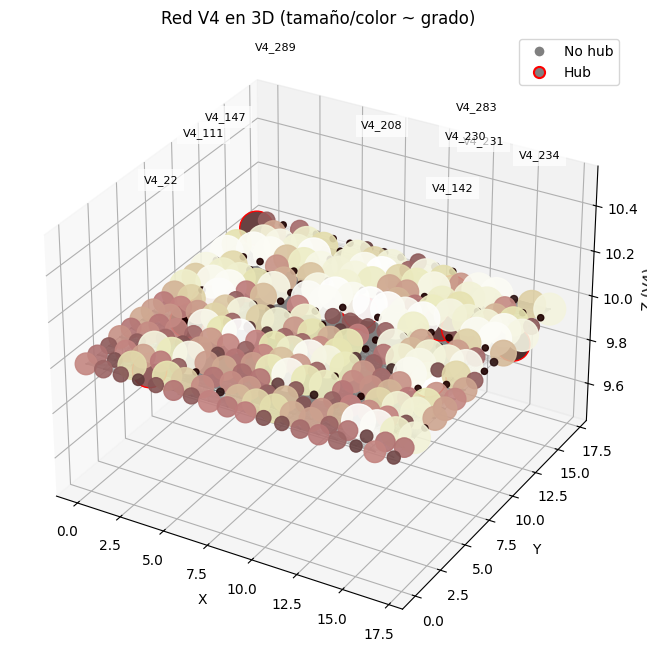

In [16]:
# Plot 3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import math

# Leyenda común: distingue hubs vs no hubs
legend_elems = [
    Line2D([0], [0], marker='o', color='w',
           label='No hub', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label='Hub',
           markerfacecolor='gray',
           markeredgecolor='red',
           markeredgewidth=1.5,
           markersize=8)
]

## V1
nodos_v1   = list(G_v1.nodes())
n_cols_v1  = int(math.ceil(np.sqrt(len(nodos_v1))))
hub_v1_set = {n for (n, _) in hubs_v1}   # nombres de hubs

# Coordenadas en rejilla (X, Y, Z=0)
coords_v1 = {
    nodo: (k % n_cols_v1, k // n_cols_v1, 0.0)
    for k, nodo in enumerate(nodos_v1)
}

fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111, projection='3d')

xs_h = []; ys_h = []; zs_h = []; s_h = []; c_h = []
xs_n = []; ys_n = []; zs_n = []; s_n = []; c_n = []

for nodo in nodos_v1:
    x, y, z = coords_v1[nodo]
    d = grados_v1[nodo]
    size  = 20 + 4*d
    color = d

    if nodo in hub_v1_set:
        xs_h.append(x); ys_h.append(y); zs_h.append(z)
        s_h.append(size); c_h.append(color)
    else:
        xs_n.append(x); ys_n.append(y); zs_n.append(z)
        s_n.append(size); c_n.append(color)

# Nodos no hub / hubs
ax.scatter(xs_n, ys_n, zs_n, s=s_n, c=c_n, cmap='bone', alpha=0.9)
ax.scatter(xs_h, ys_h, zs_h, s=s_h, c=c_h, cmap='bone',
           edgecolors="red", linewidths=1.0, alpha=1.0)

# Aristas
for u, v in G_v1.edges():
    x1, y1, z1 = coords_v1[u]
    x2, y2, z2 = coords_v1[v]
    ax.plot([x1, x2], [y1, y2], [z1, z2],
            alpha=0.15, linewidth=0.5, color="gray")

# Etiquetas de hubs
for nodo in hub_v1_set:
    x, y, z = coords_v1[nodo]
    ax.text(
        x, y, z + 0.8, nodo,
        fontsize=8,
        color="black",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )

ax.legend(handles=legend_elems, loc='upper right')
ax.set_title("Red V1 en 3D (tamaño/color ~ grado)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z (V1)")
ax.grid(True)
plt.show()

## V4
nodos_v4   = list(G_v4.nodes())
n_cols_v4  = int(math.ceil(np.sqrt(len(nodos_v4))))
hub_v4_set = {n for (n, _) in hubs_v4}

# Coordenadas en rejilla (X, Y, Z=0)
coords_v4 = {
    nodo: (k % n_cols_v4, k // n_cols_v4, 10.0)
    for k, nodo in enumerate(nodos_v4)
}

fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111, projection='3d')

xs_h = []; ys_h = []; zs_h = []; s_h = []; c_h = []
xs_n = []; ys_n = []; zs_n = []; s_n = []; c_n = []

for nodo in nodos_v4:
    x, y, z = coords_v4[nodo]
    d = grados_v4[nodo]
    size  = 20 + 4*d
    color = d

    if nodo in hub_v4_set:
        xs_h.append(x); ys_h.append(y); zs_h.append(z)
        s_h.append(size); c_h.append(color)
    else:
        xs_n.append(x); ys_n.append(y); zs_n.append(z)
        s_n.append(size); c_n.append(color)

ax.scatter(xs_n, ys_n, zs_n, s=s_n, c=c_n, cmap='pink', alpha=0.9)
ax.scatter(xs_h, ys_h, zs_h, s=s_h, c=c_h, cmap='pink',
           edgecolors="red", linewidths=1.0, alpha=1.0)

for u, v in G_v4.edges():
    x1, y1, z1 = coords_v4[u]
    x2, y2, z2 = coords_v4[v]
    ax.plot([x1, x2], [y1, y2], [z1, z2],
            alpha=0.15, linewidth=0.5, color="gray")

for nodo in hub_v4_set:
    x, y, z = coords_v4[nodo]
    ax.text(
        x, y, z + 0.8, nodo,
        fontsize=8,
        color="black",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )

ax.legend(handles=legend_elems, loc='upper right')
ax.set_title("Red V4 en 3D (tamaño/color ~ grado)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z (V4)")
ax.grid(True)
plt.show()

# Extra para conclusiones
(Resultados, discusión y conclusiones se detallan en el reporte).

a) Elegí el umbral p75 porque:
- p25 y p50 vuelven más densa la red, pero con conexiones débiles.
- p75 deja nodos aislados 37% en V1 vs 14% en V4 (ver abajo).

In [21]:
# V1
grados_v1 = dict(G_v1.degree())
num_nodos_v1 = len(grados_v1)
num_cero_v1  = sum(1 for d in grados_v1.values() if d == 0)

num_cero_v1, num_nodos_v1, num_cero_v1 / num_nodos_v1 # Esto lo vimos también en la distribución de grado

(86, 232, 0.3706896551724138)

In [20]:
# V4
grados_v4 = dict(G_v4.degree())
num_nodos_v4 = len(grados_v4)
num_cero_v4  = sum(1 for d in grados_v4.values() if d == 0)

num_cero_v4, num_nodos_v4, num_cero_v4 / num_nodos_v4 # Esto lo vimos también en la distribución de grado

(45, 318, 0.14150943396226415)